In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [5]:
from master import *
from models import *
from torchsummary import summary
import matplotlib.pyplot as plt

In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DATASET='large'
ROOT_DIR = f'/beegfs/bva212/fma_{DATASET}_cqt/'
PATH_FILE = 'checksums'
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TRANSFORM_PROB  = 0.5
SR = 22050
MODEL_SAVE_PATH = '/beegfs/sc6957/capstone/models/'
MODE = 'jigsaw'
MODEL_ARCHITECTURE = 'snet2'  #['l3net','snet',snet2',anet']
SEPARABLE = False
REDUCE_TWO_CLASS = True #Applies to jigsaw (6-class to 2-class)
NUM_SECONDS=10
TRANSFORM_DATA = False

In [8]:
start = time.time()
MODEL,MODEL_NAME = load_model(DEVICE, MODEL_ARCHITECTURE, MODE, SEPARABLE)
master = Master(DEVICE, ROOT_DIR, PATH_FILE, SR, BATCH_SIZE, VAL_SPLIT, TRANSFORM_PROB, REDUCE_TWO_CLASS, MODE, MODEL, NUM_SECONDS, TRANSFORM_DATA)
print(f'time for instantiating audio net object - {time.time() - start}')

Instantiating Model snet2_jigsaw
Number of Seconds: 10
MODE: jigsaw
Getting Train & Validation Datasets
Excluding 20000 files
There are a total of 86436 music files in the root directory
# Training samples: 69148 	 # Validation samples: 17287
	 --Done
Creating Train & Validation Dataloaders
Length of Train dataloader: 2161 	 Validation dataloader: 541
	 --Done
	 --Done
Init actions done
time for instantiating audio net object - 0.5356864929199219


In [9]:
# start = time.time()
# batch = next(iter(master.dataloaders['train']))
# print(f'time for fetching one batch - {time.time() - start}')

In [10]:
master.model

snet2_jigsaw(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(5, 5))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(5, 5))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (10): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [11]:
master.input_size

torch.Size([3, 84, 135])

In [12]:
summary(master.model,input_size=master.input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 45, 71]             416
       BatchNorm2d-2           [-1, 16, 45, 71]              32
              ReLU-3           [-1, 16, 45, 71]               0
            Conv2d-4           [-1, 32, 26, 39]          12,832
       BatchNorm2d-5           [-1, 32, 26, 39]              64
              ReLU-6           [-1, 32, 26, 39]               0
            Conv2d-7           [-1, 64, 32, 45]          51,264
       BatchNorm2d-8           [-1, 64, 32, 45]             128
              ReLU-9           [-1, 64, 32, 45]               0
        AvgPool2d-10           [-1, 64, 10, 15]               0
           Conv2d-11          [-1, 128, 15, 20]         131,200
      BatchNorm2d-12          [-1, 128, 15, 20]             256
             ReLU-13          [-1, 128, 15, 20]               0
           Conv2d-14          [-1, 256,

Loading from /beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth
No of epochs: 136
no of correct: 15082tion 541/541
 total: 17287

Performance computed on valid dataset over 17287 observations 
	Acc: 0.8724
time for computation - 43.80881953239441


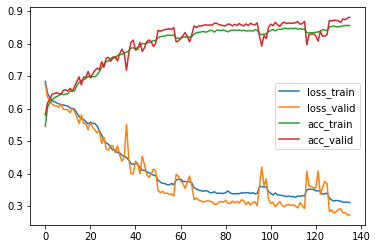

In [24]:
MODEL_LOAD_PATH = MODEL_SAVE_PATH + '20191106/' + MODEL_NAME + f'_{DATASET}_' + 'best_model.pth'
LOAD_WEIGHTS = True
print(f'Loading from {MODEL_LOAD_PATH}')
if LOAD_WEIGHTS:
    model_save_dict = torch.load(MODEL_LOAD_PATH)
    master.model.load_state_dict(model_save_dict['modelStateDict'])
    print(f"No of epochs: {len(model_save_dict['loss_dict']['train'])}")
    start = time.time()
    val_acc = master.evaluate_performance(compute_val = True)
    print(f'time for computation - {time.time() - start}')
    plt.plot(model_save_dict['loss_dict']['train'],label='loss_train')
    plt.plot(model_save_dict['loss_dict']['valid'],label='loss_valid')
    plt.plot(model_save_dict['acc_dict']['train'],label='acc_train')
    plt.plot(model_save_dict['acc_dict']['valid'],label='acc_valid')
    plt.legend()

In [20]:
MODEL_SAVE_PATH_WITH_DATE = MODEL_SAVE_PATH+datetime.now().strftime("%Y%m%d")+'/'
if not os.path.exists(MODEL_SAVE_PATH_WITH_DATE):
       os.mkdir(MODEL_SAVE_PATH_WITH_DATE)

In [25]:
MODEL_SAVE_PATH_WITH_DATE

'/beegfs/sc6957/capstone/models/20191106/'

In [ ]:
RELOAD = True
if RELOAD:
    master.train(reload_model = model_save_dict, num_epochs=200, learning_rate=1e-5, print_every=5, verbose=True, save=True, checkpoint_every=5, model_save_path = MODEL_SAVE_PATH_WITH_DATE, model_name = MODEL_NAME + f'_{DATASET}_' )
else:
    master.train(reload_model = None, num_epochs= 10, learning_rate=1e-5, print_every=5, verbose=True, save=True, checkpoint_every=5, model_save_path = MODEL_SAVE_PATH_WITH_DATE, model_name = MODEL_NAME + f'_{DATASET}_' )

Saving model at /beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_
Instantiating Optimzer, Loss Criterion, Scheduler
	 --Done
Training started
Loading previous model...
Starting Epoch: 136| Best_Val_Acc: 0.8808
